# CAUSAL INFERENCE PROCESS WITH IHDP
In order to give another example of the whole causal inference process; since the outcomes in AML dataset are not very unclear because they are
times to event and events (I am not very familiar with that kind of data), I will use the IHDP dataset, which is a semi-synthetic dataset,
where the potential outcomes are generated by a parametric model. The dataset is composed of 747 samples, where 25 covariates are generated from a
multivariate normal distribution and the treatment is binary. The potential outcomes are generated as follows:
  - The potential outcome for control group is generated as a linear combination of the features.
  - The potential outcome for treated group is generated as an exponential combination of the features.

Althoug WE KNOW how the potential outcomes are generated, we will fit parametric models to predict the potential outcomes, so we can construct a
semi-synthetic dataset, which will have the same distribution of the real data, but the outcomes will be generated by the parametric models fitted.

In [1]:
# Import libraries
import pandas as pd
import numpy as np

# import predictors of sklearn
from sklearn.linear_model import  LinearRegression
from sklearn.ensemble import  RandomForestRegressor
from sklearn.neural_network import  MLPRegressor
import matplotlib.pyplot as plt
import seaborn as sns

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

from IHDP.load_ihdp import load_ihdp
from ci_models import *

In [18]:
#Load data
database = load_ihdp()

In [19]:
# Get the features and the outcome
features = database.columns[database.columns.str.contains('x')] # columns with an 'x' in the name
treatment = 't'
outcome = 'y'
potential_outcomes = ['mu0', 'mu1']

# train parametric models to predict the potential outcomes
# define the models
models = {'mu0': LinearRegression(),
            'mu1': LinearRegression()}

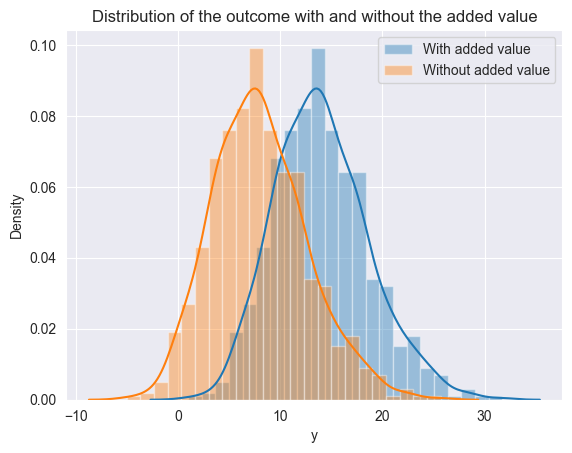

In [20]:
# since we are fitting exponential regression, the outcome must be positive: sume the minimum value of the outcome to all the values
added_value = np.abs(np.min(database[outcome])) + 1
database[outcome] = database[outcome] + added_value
# plot the distribution of the outcome with and without the added value
sns.distplot(database[outcome], label='With added value')
sns.distplot(database[outcome] - added_value, label='Without added value')
plt.legend()
plt.title('Distribution of the outcome with and without the added value')
plt.show()

In [16]:
# predict y0 as linear combination of the features
control_database = database.loc[database[treatment] == 0, :]
models['mu0'].fit(control_database[features], control_database[outcome])

LinearRegression()

In [17]:

# predict y1 as exponential combination of the features
treated_database = database.loc[database[treatment] == 1, :]
models['mu1'].fit(treated_database[features], np.log(treated_database[outcome]))

LinearRegression()

Control group
R2:  0.7049543596818768
MSE:  5.1877204985847
MAE:  1.6814266485532612
Treated group
R2:  0.8128407265794982
MSE:  4.133429596955112
MAE:  1.600195220949521


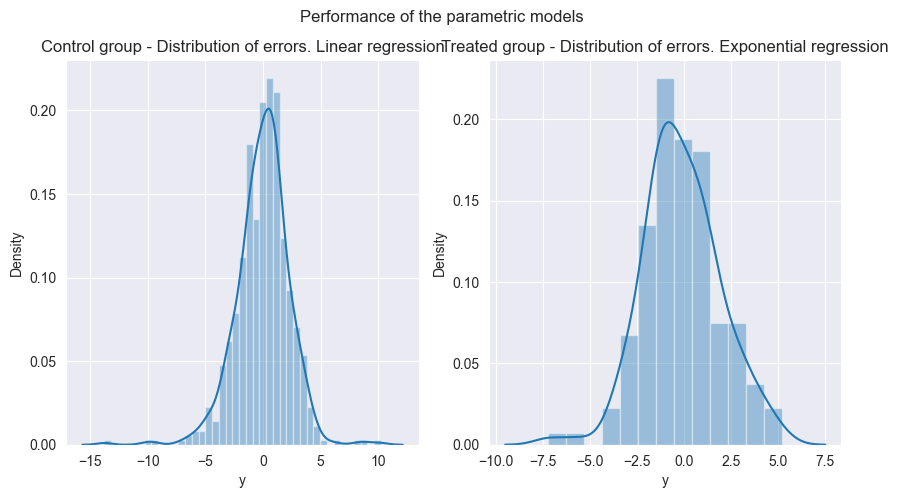

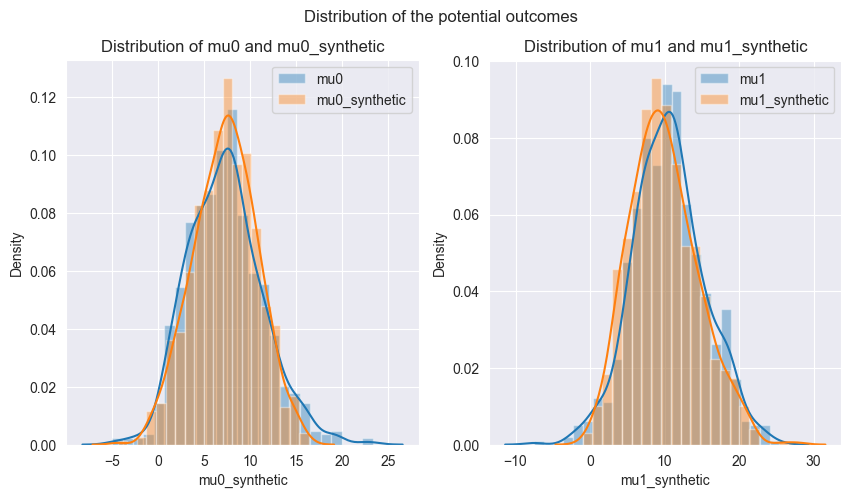

In [5]:
# check the performance of the models
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
# control group
y_pred = models['mu0'].predict(control_database[features]) - added_value
y_true = control_database[outcome] - added_value
print('Control group')
print('R2: ', models['mu0'].score(control_database[features], control_database[outcome]))
print('MSE: ', np.mean((y_pred - y_true)**2))
print('MAE: ', np.mean(np.abs(y_pred - y_true)))
#plot the errors distribution
sns.distplot(y_pred - y_true, ax=axs[0])
axs[0].set_title('Control group - Distribution of errors. Linear regression')

# treated group
y_pred = models['mu1'].predict(treated_database[features])
y_pred = np.exp(y_pred) - added_value
y_true = treated_database[outcome] - added_value
print('Treated group')
print('R2: ', models['mu1'].score(treated_database[features], np.log(treated_database[outcome])))
print('MSE: ', np.mean((y_pred - y_true)**2))
print('MAE: ', np.mean(np.abs(y_pred - y_true)))
#plot the errors distribution
sns.distplot(y_pred - y_true, ax=axs[1])
axs[1].set_title('Treated group - Distribution of errors. Exponential regression')
fig.suptitle('Performance of the parametric models')




In [ ]:

# Now, we will use the parametric models to generate the potential outcomes
# generate the potential outcomes for all database
# control group
database['mu0_synthetic'] = models['mu0'].predict(database[features]) - added_value
# treated group
database['mu1_synthetic'] = models['mu1'].predict(database[features])
database['mu1_synthetic'] = np.exp(database['mu1_synthetic']) - added_value

#plot the distribution of the potential outcomes, compare mu0 with mu0_synthetic and mu1 with mu1_synthetic
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
sns.distplot(database['mu0'], label='mu0' , ax=axs[0])
sns.distplot(database['mu0_synthetic'], label='mu0_synthetic', ax=axs[0])
axs[0].set_title('Distribution of mu0 and mu0_synthetic')
axs[0].legend()

sns.distplot(database['mu1'], label='mu1', ax=axs[1])
sns.distplot(database['mu1_synthetic'], label='mu1_synthetic', ax=axs[1])
axs[1].set_title('Distribution of mu1 and mu1_synthetic')
axs[1].legend()
fig.suptitle('Distribution of the potential outcomes')
plt.show()

In [6]:
# The factual outcome is the one that match the treatment. Is a noisy version of the potential outcome
# generate the factual outcome
database['y_synthetic'] = database[treatment] * database['mu1_synthetic'] + (1 - database[treatment]) * database['mu0_synthetic']
# add noise
database['y_synthetic'] = database['y_synthetic'] + np.random.normal(0, 0.1, size=database.shape[0])

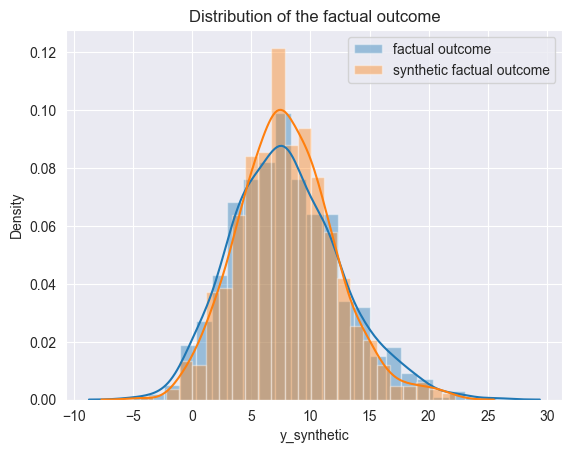

In [7]:
database[outcome] = database[outcome] - added_value
#plot the distribution of the factual outcome
sns.distplot(database[outcome], label='factual outcome')
sns.distplot(database['y_synthetic'], label='synthetic factual outcome')
plt.title('Distribution of the factual outcome')
plt.legend()
plt.show()

## CAUSAL INFERENCE METHODS

Three well known methods for causal inference are the S-learner, the T-learner and the TARNET are implementes.

As you may know, S-Learner and T-learner are model agnostic methods, so we will use a linear regression and a random forest and a Neural Network as
 base learners. The Parameters of neural networks implementations (defined in config dict) are not in the scope of this notebook.


In [8]:
# CHECK PERFORMANCE OF CAUSAL INFERENCE METHODS

config= {'slearner': {'NE':3000, 'hidden_layers': (50, 25)},
         'tlearner': {'NE':3000, 'hidden_layers': (50, 25)},
         'tarnet': {'NE': 1000, 'batch_size': 1000, 'patience':40,
                    'NL_phi': 3, 'NL_y': 2, 'NN_phi': 200, 'NN_y': 100
                    }}

ci_models = {'slearner':{"Linear Regression": LinearRegression(),
            "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
            "Neural Network": MLPRegressor(hidden_layer_sizes=config['slearner']['hidden_layers'], max_iter=config['slearner']['NE'],
                                           random_state=42)},
          'tlearner':{"Linear Regression": LinearRegression(),
            "Random Forest": RandomForestRegressor(n_estimators=100, random_state=42),
            "Neural Network": MLPRegressor(hidden_layer_sizes=config['tlearner']['hidden_layers'], max_iter=config['tlearner']['NE'],
                                           random_state=42)},
          'tarnet': {'TARNET': None},
}

In [9]:
tarnet = make_tarnet(25) # keras model
print(tarnet.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 25)]                 0         []                            
                                                                                                  
 phi_1 (Dense)               (None, 200)                  5200      ['input[0][0]']               
                                                                                                  
 phi_2 (Dense)               (None, 200)                  40200     ['phi_1[0][0]']               
                                                                                                  
 phi_3 (Dense)               (None, 200)                  40200     ['phi_2[0][0]']               
                                                                                             

In [10]:
# make several train-test splits of the dataset
Num_exps = 10
# make splits
pehe_dict = {ci_model:{} for ci_model in ci_models.keys()}
ate_dict = {ci_model:{} for ci_model in ci_models.keys()}
for i_exp in range(1, Num_exps+1):
    print(f'Experiment {i_exp}')
    # make train-test split
    train = database.sample(frac=0.7, random_state=i_exp)
    test = database.loc[~database.index.isin(train.index), :]
    # get the features and the outcome
    x_train, t_train, y_train = train.loc[:, features], train.loc[:, 't'], train.loc[:, 'y']
    x_test, t_test, y_test = test.loc[:, features], test.loc[:, 't'], test.loc[:, 'y']
    data = {'data_train': (x_train, t_train, y_train), 'data_test': (x_test, t_test, y_test)}
    true_y = {'y_train': y_train, 'y_test': y_test, 'mu0_train': train.loc[:, 'mu0'], 'mu1_train': train.loc[:, 'mu1'],
                'mu0_test': test.loc[:, 'mu0'], 'mu1_test': test.loc[:, 'mu1']}
    # fit the causal inference models
    for ci_model in ci_models.keys():
        predicted_y = predict_causal_effects(ci_models[ci_model], data,
                                             learner=ci_model, config=config)
        pehe, ate_error = evaluate_causal_inference(ci_models[ci_model], true_y, predicted_y)
        pehe_dict[ci_model][f'exp_{i_exp}'] = pehe
        ate_dict[ci_model][f'exp_{i_exp}'] = ate_error


Experiment 1
Model: Linear Regression, MSE on train data: 7.40
Model: Linear Regression, MSE on test data: 6.55
Model: Linear Regression, PEHE (Train): 4.72
Model: Linear Regression, PEHE (Test): 3.78
Model: Random Forest, MSE on train data: 1.00
Model: Random Forest, MSE on test data: 5.53
Model: Random Forest, PEHE (Train): 2.78
Model: Random Forest, PEHE (Test): 2.59
Model: Neural Network, MSE on train data: 0.04
Model: Neural Network, MSE on test data: 4.57
Model: Neural Network, PEHE (Train): 2.68
Model: Neural Network, PEHE (Test): 2.81
Model: Linear Regression, MSE on train data: 5.05
Model: Linear Regression, MSE on test data: 5.69
Model: Linear Regression, PEHE (Train): 2.93
Model: Linear Regression, PEHE (Test): 2.75
Model: Random Forest, MSE on train data: 0.98
Model: Random Forest, MSE on test data: 6.29
Model: Random Forest, PEHE (Train): 2.70
Model: Random Forest, PEHE (Test): 2.87
Model: Neural Network, MSE on train data: 0.05
Model: Neural Network, MSE on test data: 2.9

 ### PEHE ERROR PLOTS

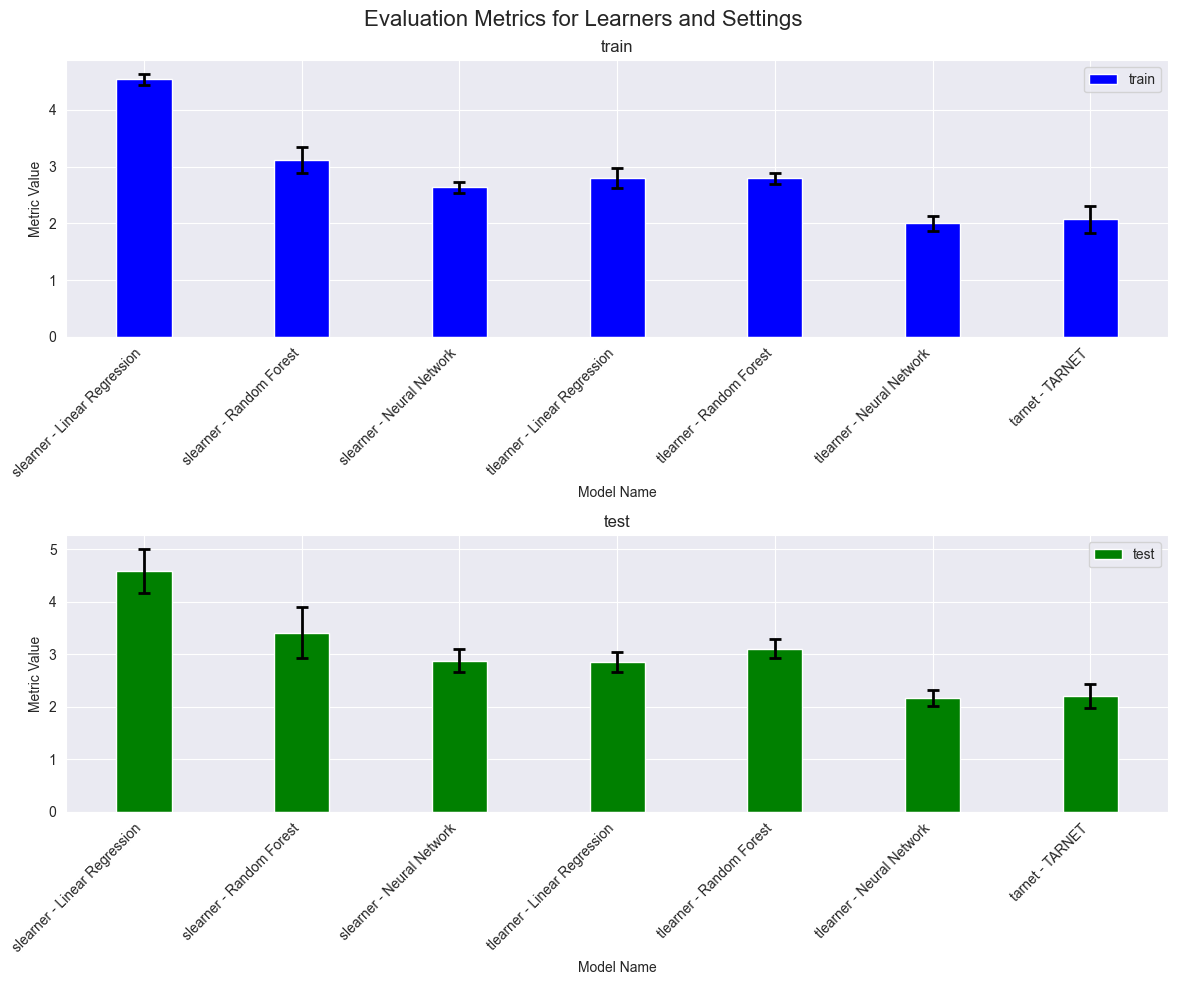

In [11]:
plot_mean_pehes(Num_exps, ci_models.keys(),  pehe_dict)

### ATE ERROR PLOTS

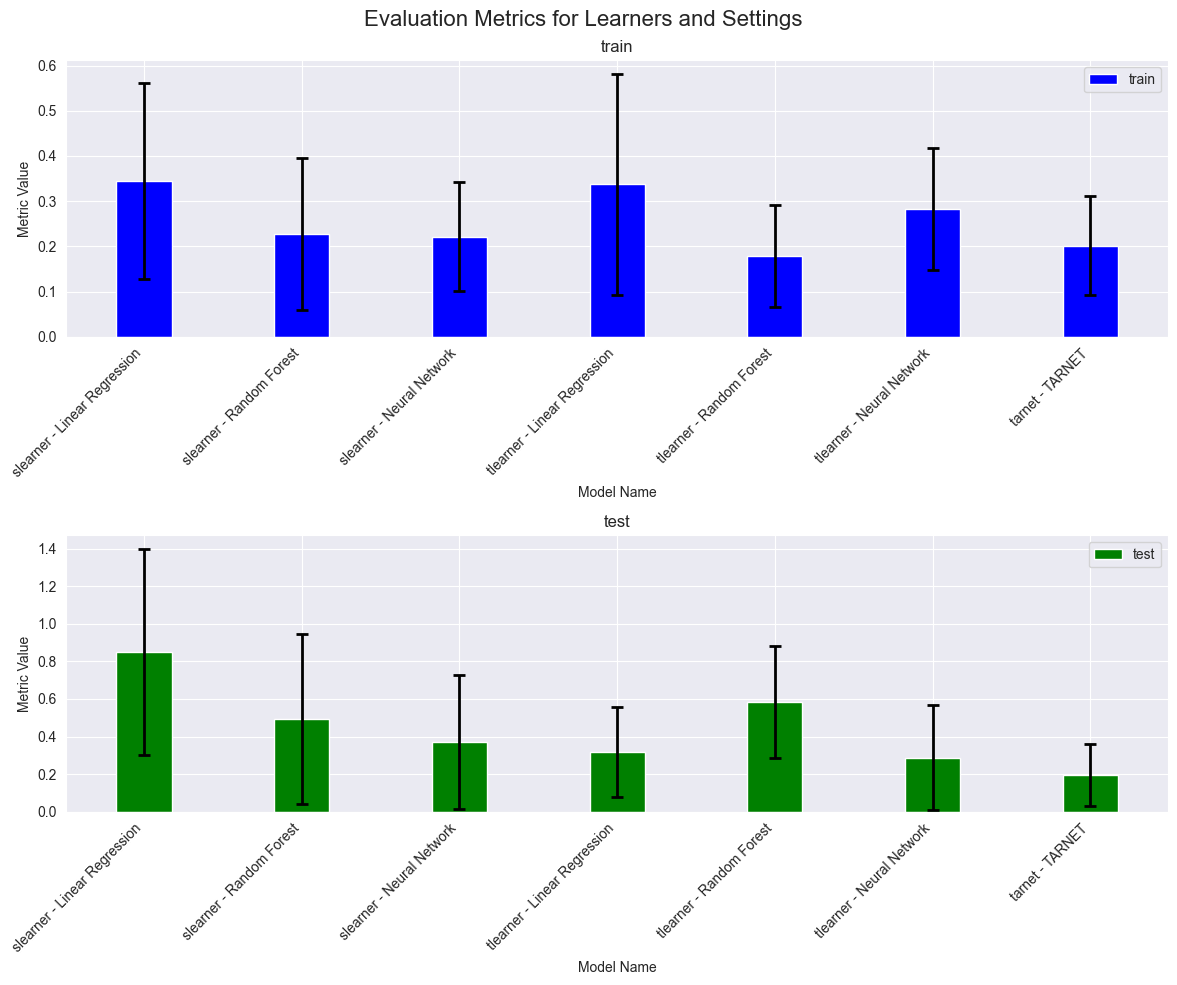

In [12]:
plot_mean_pehes(Num_exps, ci_models.keys(),  ate_dict)